In [25]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as  optim
from torchvision import datasets
from torch.utils.data import DataLoader

from torch.autograd import Variable
import pandas as pd
import numpy as np
import os

In [ ]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

!unzip celeba.zip -d data_faces
!rm -r celeba.zip


In [23]:

!gdown --id 1s1ILu5QLJbV-rBGVkWxIzKz6G1ExjnJV
!unzip list_attr_celeba.csv.zip -d data_faces
!rm -r list_attr_celeba.csv.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1s1ILu5QLJbV-rBGVkWxIzKz6G1ExjnJV
To: /content/list_attr_celeba.csv.zip
100% 2.12M/2.12M [00:00<00:00, 124MB/s]
Archive:  list_attr_celeba.csv.zip
  inflating: data_faces/list_attr_celeba.csv  


In [3]:
from torch.utils.data import Dataset

In [4]:
if not os.path.exists('outputs'):
    os.makedirs('outputs')

In [5]:
import torchvision.utils as vutils
def display_grid(images,
                 nrow=8,
                 figsize=(12,12)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(
        np.transpose(
            vutils.make_grid(images, nrow=nrow, padding=2, normalize=True).cpu(),(1,2,0)
        )
    )
    plt.axis('off')


In [6]:
class VAE(nn.Module):
    def __init__(self, image_size=128, latent_dim=512):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Define the parameters for mean and variance
        self.fc_mu = nn.Linear(256 * (image_size // 16) * (image_size // 16), latent_dim)
        self.fc_logvar = nn.Linear(256 * (image_size // 16) * (image_size // 16), latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * (image_size // 16) * (image_size // 16))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        self.image_size=image_size

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, (self.image_size // 16), (self.image_size // 16))
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, logvar

In [7]:


re_size = 128

transform = transforms.Compose(
    [transforms.Resize(size=(re_size, re_size), interpolation=Image.BICUBIC),
     transforms.ToTensor()])

batch_size = 64
celeba_data = datasets.ImageFolder('data_faces', transform=transform)
celeba_loader = DataLoader(celeba_data,batch_size=batch_size,shuffle=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
#Downloading pretrained model weights
!gdown --id 1iUkeqsRdaADfCnczvx2-jkcT2bHLUyPd

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1iUkeqsRdaADfCnczvx2-jkcT2bHLUyPd
From (redirected): https://drive.google.com/uc?id=1iUkeqsRdaADfCnczvx2-jkcT2bHLUyPd&confirm=t&uuid=73271909-6952-4a4b-bf9f-a8954345327a
To: /content/celeba_vae.pth
100% 106M/106M [00:06<00:00, 16.3MB/s] 


In [10]:
# Initialize VAE model
model = VAE().to(device)
model.load_state_dict(torch.load('celeba_vae.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=16384, out_features=512, bias=True)
  (fc_logvar): Linear(in_features=16384, out_features=512, bias=True)
  (decoder_input): Linear(in_features=512, out_features=16384, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspo

# Image Generation


In [11]:
batch, _ = next(iter(celeba_loader))

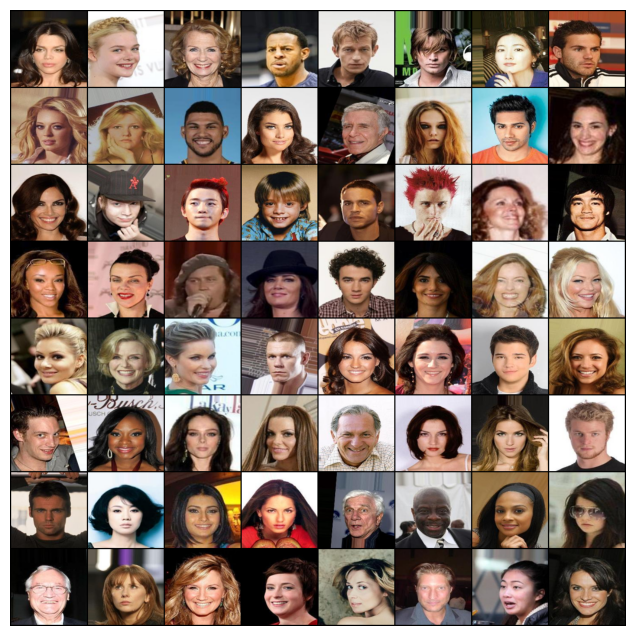

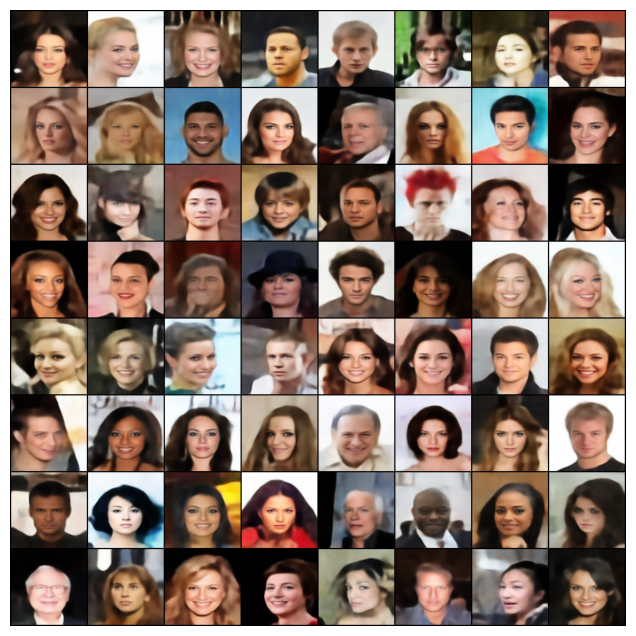

In [12]:

reconstructions,_,_ = model(batch.cuda())
display_grid(batch, figsize=(8,8))
display_grid(reconstructions.to('cpu'), figsize=(8,8))


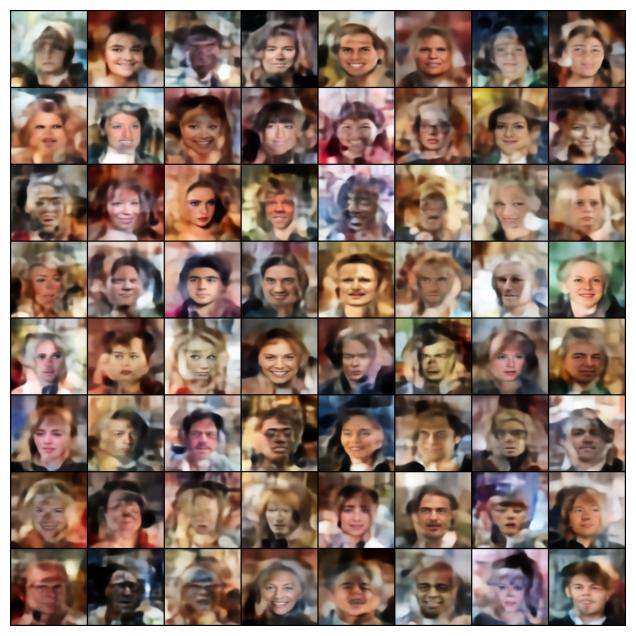

In [13]:
sampled_latents=torch.randn(len(batch),512).cuda()

with torch.no_grad():
    reconstructed_x = model.decode(sampled_latents)#.permute(0,2,3,1).detach().clip(0,1).cpu().numpy()

display_grid(reconstructed_x.detach().clip(0,1).cpu(), figsize=(8,8))

#  Vector Interpolation


In [14]:
# Target images to interpolate
target_images = [2,6]
reconstructed_x, mu, logvar=model(batch[target_images].cuda())

In [15]:
latents=model.reparameterize( mu, logvar).detach().cpu().numpy()

In [16]:

vectors = []
ratios = np.linspace(0, 1, num=10)
# Vectors interpolation
for ratio in ratios:
            v = (1.0 - ratio) * latents[0] + ratio * latents[1]
            vectors.append(v)

vectors = np.asarray(vectors)

In [17]:
with torch.no_grad():
    reconstructed_x = model.decode(torch.from_numpy(vectors).cuda()).permute(0,2,3,1).detach().clip(0,1).cpu().numpy()

In [18]:
plt.imshow(batch[target_images].permute(0,2,3,1).detach().clip(0,1).cpu().numpy()[0])
plt.axis('off')


plt.imshow(batch[target_images].permute(0,2,3,1).detach().clip(0,1).cpu().numpy()[1])
plt.axis('off')


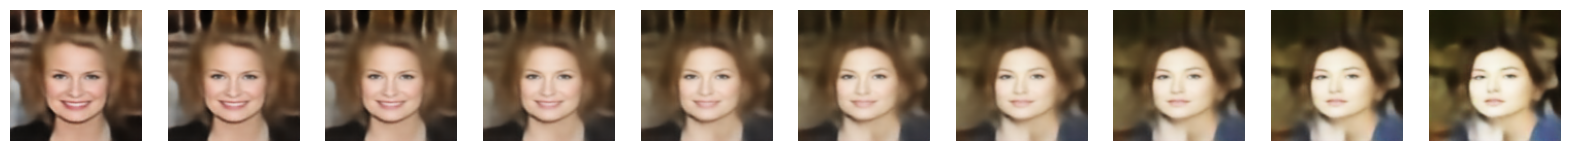

In [19]:


# Plot interpolated images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(reconstructed_x[i])
    axes[i].axis('off')
plt.show()

# Image Attributes Modification

In [44]:
class CelebADataset(Dataset):
    def __init__(self, data, labels,classes, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.classes = classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(os.path.join('data_faces','img_align_celeba',self.data[idx])).convert('RGB')
        label = torch.Tensor(self.labels[idx,[39,20,22,2,31,15]].astype('uint8'))
        if self.transform:
            img = self.transform(img)
        sample = {'images': img, 'labels': label}
        return sample

In [26]:
#list_attr_celeba.csv: Attribute labels for each image.
#There are 40 attributes. "1" represents positive while "-1" represents negative
df = pd.read_csv("data_faces/list_attr_celeba.csv")
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [47]:
values=df.values
values[:,1:]=(values[:,1:]+1)//2 # Map -1 to 0
classes=df.columns[1:]

In [48]:
values.shape

(202599, 41)

In [29]:
classes.shape

(40,)

In [30]:
classes[[39,20,22,2,31,15]]

Index(['Young', 'Male', 'Mustache', 'Attractive', 'Smiling', 'Eyeglasses'], dtype='object')

In [33]:
np.mean(values[:,15])

0.06511878143524893

In [34]:
#Select the image attribute to be modified
att_idxs=[39,20,22,2,31,15]
att_names=classes[att_idxs]
att_names

Index(['Young', 'Male', 'Mustache', 'Attractive', 'Smiling', 'Eyeglasses'], dtype='object')

In [42]:
att_idx=20+1 # add 1 for the first column

In [50]:
#Compute the editing direction for a given attribute
if not os.path.exists(os.path.join('outputs',classes[att_idx-1]+'neg_pos.npy')):
    #Create a data loader for negative and positive classes
    neg_data = CelebADataset(values[values[:,att_idx]==0,0], values[values[:,att_idx]==0,1:],classes,transform)
    pos_data = CelebADataset(values[values[:,att_idx]==1,0], values[values[:,att_idx]==1,1:],classes,transform)

    neg_loader = DataLoader(neg_data,batch_size=256)
    pos_loader = DataLoader(pos_data,batch_size=256)
    #Project the image into the latent space.
    print('Negative Latent')
    neg_latent=torch.zeros(512)
    cpt=0
    with torch.no_grad():
        for batch_idx, data in enumerate(neg_loader ):
                imgs, labels= data['images'].float().to(device),data['labels'].long().to(device)

                recon_img, mu, logvar = model(imgs)
                neg_latent+=torch.sum(model.reparameterize(mu, logvar).detach().cpu(),0)
                cpt+=64
                if batch_idx % 100 == 0:
                    print('Step [{}/{}] '.format(batch_idx+1, len(neg_loader)))
    neg_latent/=cpt
    print('Postive Latent')
    pos_latent=torch.zeros(512)
    cpt=0
    with torch.no_grad():
        for batch_idx, data in enumerate(pos_loader ):
                imgs, labels= data['images'].float().to(device),data['labels'].long().to(device)

                recon_img, mu, logvar = model(imgs)
                pos_latent+=torch.sum(model.reparameterize(mu, logvar).detach().cpu(),0)
                cpt+=64
                if batch_idx % 10 == 0:
                    print('Step [{}/{}] '.format(batch_idx+1, len(pos_loader)))
    pos_latent/=cpt
    V=(pos_latent-neg_latent).detach().cpu().numpy()[0]
    V /= np.linalg.norm(V)
    np.save(os.path.join('outputs',classes[att_idx-1]+'neg_pos.npy'),V)
else:
    V=np.load(os.path.join('outputs',classes[att_idx-1]+'neg_pos.npy'))


Negative Latent
Step [1/462] 
Step [101/462] 
Step [201/462] 
Step [301/462] 
Step [401/462] 
Postive Latent
Step [1/330] 
Step [11/330] 
Step [21/330] 
Step [31/330] 
Step [41/330] 
Step [51/330] 
Step [61/330] 
Step [71/330] 
Step [81/330] 
Step [91/330] 
Step [101/330] 
Step [111/330] 
Step [121/330] 
Step [131/330] 
Step [141/330] 
Step [151/330] 
Step [161/330] 
Step [171/330] 
Step [181/330] 
Step [191/330] 
Step [201/330] 
Step [211/330] 
Step [221/330] 
Step [231/330] 
Step [241/330] 
Step [251/330] 
Step [261/330] 
Step [271/330] 
Step [281/330] 
Step [291/330] 
Step [301/330] 
Step [311/330] 
Step [321/330] 


Text(0.5, 1.0, 'Original Male 0')

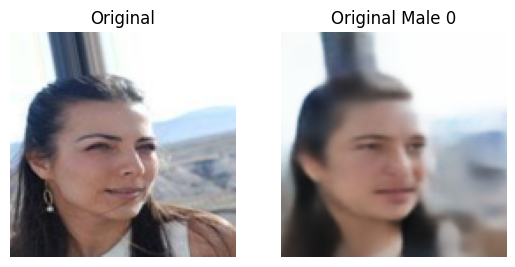

In [52]:

label_cls=0#np.random.choice(2)
idxs=np.where(values[:,att_idx]==label_cls)[0]
sample_idx=idxs[np.random.choice(len(idxs))]


img = Image.open(os.path.join('data_faces','img_align_celeba',values[sample_idx,0])).convert('RGB')
img = transform(img).unsqueeze(0).float().cuda()


with torch.no_grad():
    reconstructions,mu, logvar= model(img)
    reconstructions=reconstructions.detach().cpu().clip(0,1)



plt.subplot(121)
plt.imshow(img.permute(0,2,3,1).cpu().numpy()[0])
plt.axis('off')
plt.title('Original')
plt.subplot(122)
plt.imshow(reconstructions.permute(0,2,3,1).numpy()[0])
plt.axis('off')
plt.title('Original '+classes[att_idx-1]+' %d'%(label_cls))





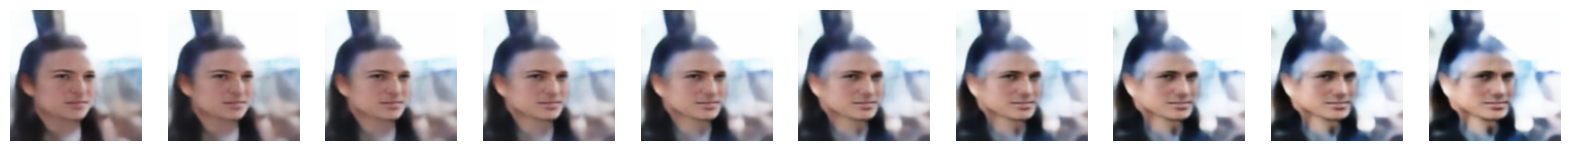

In [53]:
#######################################################
latents=model.reparameterize( mu, logvar).detach().cpu().numpy()


vectors = []
ratios = np.linspace(0, 1, num=10)
# Vectors interpolation
for ratio in ratios:
            if label_cls==0:
                v = latents[0] + ratio * V
            else:
                v = latents[0] - ratio * V

            vectors.append(v)

vectors = np.asarray(vectors)

reconstructed_x = model.decode(torch.from_numpy(vectors).cuda()).permute(0,2,3,1).detach().clip(0,1).cpu().numpy()


# Plot interpolated images
fig, axes = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    axes[i].imshow(reconstructed_x[i])
    axes[i].axis('off')
plt.show()